In [1]:
using Distributions
using Random
using Rocket
using ReactiveMP
using GraphPPL
using LinearAlgebra

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future warnings for GraphPPL are suppressed.


In [2]:
@model function hgf(ap, P, Q, κ, ω)

    zv_min_mean = datavar(Float64)
    zv_min_var  = datavar(Float64)
    
    sv_min_mean = datavar(Float64)
    sv_min_var  = datavar(Float64)
    
    # Fixed priors for the first observation
    zv_min ~ NormalMeanVariance(zv_min_mean, zv_min_var)
    sv_min ~ NormalMeanVariance(sv_min_mean, sv_min_var)
    
    # Z-Layer transition factorised as a Mean-Field 
    zv ~ NormalMeanVariance(zv_min, Q) where { q = MeanField() }
    
    # We use Gauss Hermite approximation to approximate nonlinearity between layers
    meta = GCVMetadata(GaussHermiteCubature(ap))
    
    # Structured factorisation around Gaussian Controlled Variance node used in HGF model
    gcv, sv ~ GCV(sv_min, zv, κ, ω) where { q = q(sv, sv_min)q(zv)q(κ)q(ω), meta = meta }
    
    yv = datavar(Float64)
    
    # Observations 
    yv ~ NormalMeanPrecision(sv, P)

    return zv_min_mean, zv_min_var, sv_min_mean, sv_min_var, gcv, zv, sv, yv
end

hgf (generic function with 1 method)

In [3]:
function generate_test_data(n, observations_precision, z_layer_precision, κ, ω)
    
    z_data = Vector{Float64}(undef, n)
    s_data = Vector{Float64}(undef, n)
    y_data = Vector{Float64}(undef, n)
    
    y_σ = sqrt(inv(observations_precision))
    z_σ = sqrt(inv(z_layer_precision))
    
    z_data[1] = zero(Float64)
    s_data[1] = zero(Float64)
    y_data[1] = rand(Normal(s_data[1], y_σ))
    
    for i in 2:n
        z_data[i] = rand(Normal(z_data[i - 1], z_σ))
        s_data[i] = rand(Normal(s_data[i - 1], sqrt(exp(κ * z_data[i] + ω))))
        y_data[i] = rand(Normal(s_data[i], y_σ))
    end
    
    return z_data, s_data, y_data
end

generate_test_data (generic function with 1 method)

In [30]:
function inference(data, criterion, ap, yp, zp, κ, ω)

    zm = keep(Marginal)
    sm = keep(Marginal)
    fe = ScoreActor(Float64)

    model, (zv_min_mean, zv_min_var, sv_min_mean, sv_min_var, gcv, zv, sv, yv) = hgf(ap, yp, zp, κ, ω)
    
    scheduler = PendingScheduler()
    
    fe_scheduler = PendingScheduler()
    
    fsub = subscribe!(score(Float64, BetheFreeEnergy(), model, fe_scheduler), fe)
    
    zsub = subscribe!(getmarginal(zv) |> schedule_on(scheduler), zm)
    ssub = subscribe!(getmarginal(sv) |> schedule_on(scheduler), sm)
    
    z_prior_sub = subscribe!(getmarginal(zv) |> schedule_on(scheduler), (z_posterior) -> begin
        update!(zv_min_mean, mean(z_posterior))
        update!(zv_min_var, var(z_posterior))
    end)
    
    s_prior_sub = subscribe!(getmarginal(sv) |> schedule_on(scheduler), (s_posterior) -> begin
        update!(sv_min_mean, mean(s_posterior))
        update!(sv_min_var, var(s_posterior))
    end)
    
    setmarginal!(sv, NormalMeanVariance(0.0, 5.0))
    setmarginal!(zv, NormalMeanVariance(0.0, 5.0))
    setmarginal!(gcv, :y_x, MvNormalMeanCovariance([ 0.0, 0.0 ], [ 5.0, 5.0 ]))

    update!(zv_min_mean, 0.0)
    update!(zv_min_var, 100.0)
    update!(sv_min_mean, 0.0)
    update!(sv_min_var, 100.0)
    
    for observation in data
        
        update!(yv, observation)
        
        iters = repeat!(model, criterion) do _
            release!(fe_scheduler)
        end
        
        release!(fe)
        release!(scheduler)
    end
        
    unsubscribe!(z_prior_sub)
    unsubscribe!(s_prior_sub)
    unsubscribe!(zsub)
    unsubscribe!(ssub)
    unsubscribe!(fsub)
    
    return getvalues(zm), getvalues(sm), getvalues(fe), fe
end

inference (generic function with 1 method)

In [31]:
Random.seed!(2178)

n  = 100
yp = 0.1
zp = 1.0
κ = 1.0
ω = 0.0

z_data, s_data, y_data = generate_test_data(n, yp, zp, κ, ω);

In [32]:
ap        = 20
criterion = 10
# criterion = UntilConvergence(tolerance = 1e-10)

@time zm, sm, fe, _fe = inference(y_data, criterion, ap, yp, zp, κ, ω);

  0.565179 seconds (1.17 M allocations: 60.498 MiB, 4.22% gc time)


In [33]:
fe

10-element Array{Float64,1}:
 367.09907818470134
 363.55104078649543
 362.53403379090173
 362.1698923570176
 362.02267700549055
 361.9524422866106
 361.91386621800604
 361.8902962272106
 361.87468081887965
 361.86367323114854

In [7]:
first(fe) - last(fe)

19.37695865470937

In [386]:
mean.(zm)

2-element Array{Float64,1}:
 -0.46732495229705523
 -0.5018259635958262

In [368]:
first(fe) - last(fe) # 10

20.66622095963055

In [232]:
using Plots
using PGFPlotsX

pgfplotsx()

PGFPlotsX.latexengine!(PGFPlotsX.PDFLATEX);

In [334]:
gr()

Plots.GRBackend()

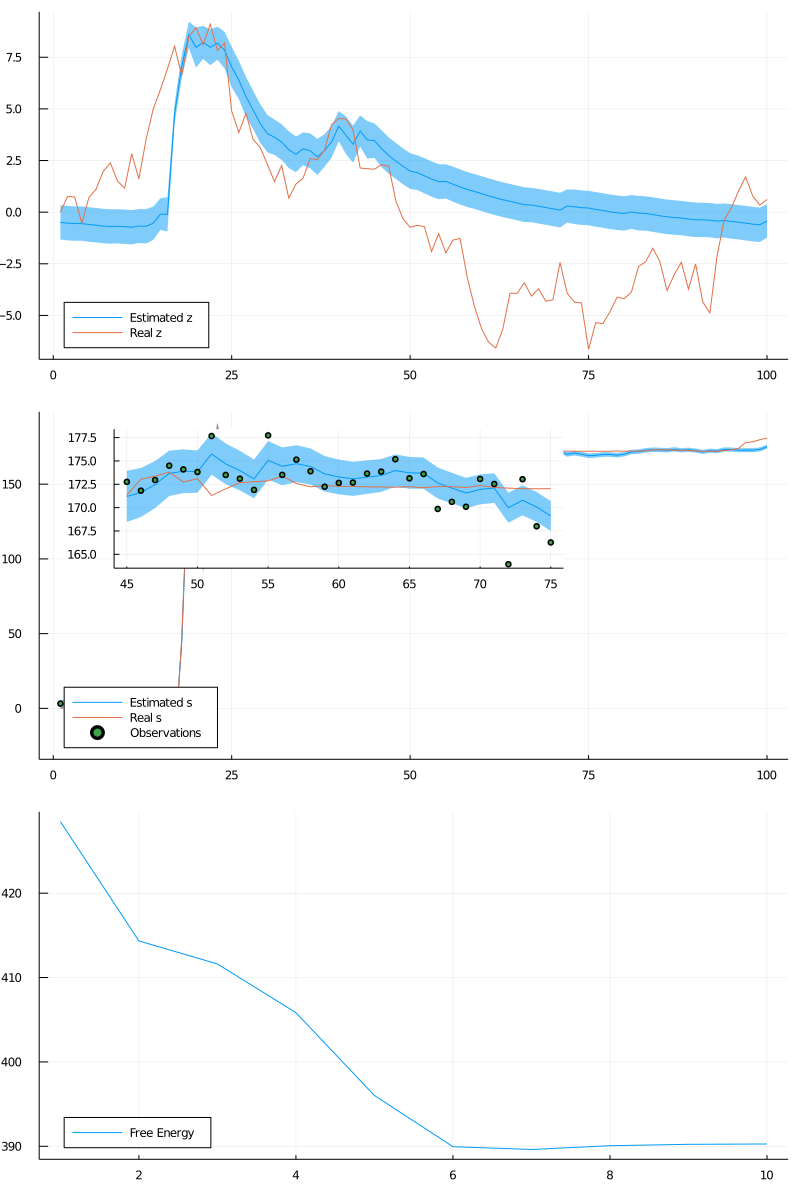

In [335]:
layer1p = plot(mean.(zm), ribbon = std.(zm), label = "Estimated z", legend = :bottomleft)
layer1p = plot!(layer1p, z_data, label = "Real z")

layer2p = plot(mean.(sm), ribbon = std.(sm), label = "Estimated s", legend = :bottomleft)
layer2p = plot!(layer2p, s_data, label = "Real s")
layer2p = scatter!(layer2p, y_data[1:1], label = "Observations", ms = 3)

lens_limits = [ 45, 75 ]
lens_range = first(lens_limits):last(lens_limits)
s = 4.0

layer2p = plot!(layer2p, lens_range, mean.(sm)[lens_range], ribbon = std.(sm)[lens_range], inset = (1, bbox(0.1,0.05,0.6,0.4)), label = "Estimated s", subplot = 2, legend = false)
layer2p = plot!(layer2p, lens_range, s_data[lens_range], label = "Real s", subplot = 2)
layer2p = scatter!(layer2p, lens_range, y_data[lens_range], label = "Observations", ms = 3, subplot = 2)
# layer2p = plot!(layer2p, -5:8, (-5:8).^2, subplot = 2)

# layer2p = lens!(layer2p, lens_x, [ minimum(s_data[first(lens_x):last(lens_x)]) - s, maximum(s_data[first(lens_x):last(lens_x)]) + 1.0 ], inset = (1, bbox(0.4, 0.45, 0.6, 0.45)))

# @show scene.plots

fep = plot(fe, label = "Free Energy", legend = :bottomleft)

plot(layer1p, layer2p, fep, layout = @layout([ a; b; c ]), size = (800, 1200))

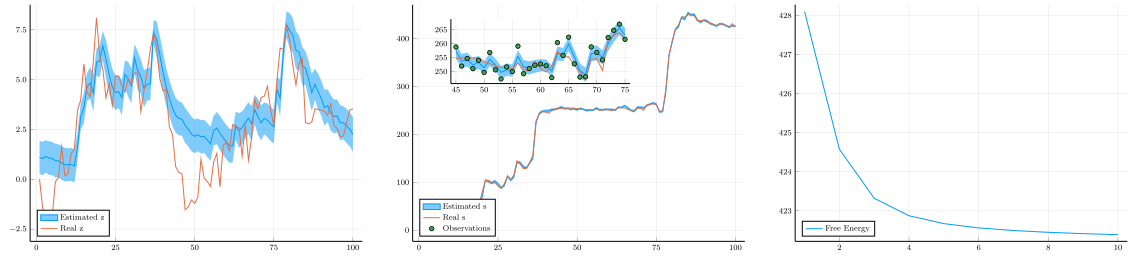

In [257]:
layer1p = plot(mean.(zm), ribbon = std.(zm), label = "Estimated z", legend = :bottomleft)
layer1p = plot!(layer1p, z_data, label = "Real z")

layer2p = plot(mean.(sm), ribbon = std.(sm), label = "Estimated s", legend = :bottomleft)
layer2p = plot!(layer2p, s_data, label = "Real s")
layer2p = scatter!(layer2p, y_data[1:1], label = "Observations", ms = 3)

lens_limits = [ 45, 75 ]
lens_range = first(lens_limits):last(lens_limits)
s = 4.0

layer2p = plot!(layer2p, lens_range, mean.(sm)[lens_range], ribbon = std.(sm)[lens_range], inset = (1, bbox(0.1,0.05,0.6,0.4)), label = "Estimated s", subplot = 2, legend = false)
layer2p = plot!(layer2p, lens_range, s_data[lens_range], label = "Real s", subplot = 2)
layer2p = scatter!(layer2p, lens_range, y_data[lens_range], label = "Observations", ms = 3, subplot = 2)
# layer2p = plot!(layer2p, -5:8, (-5:8).^2, subplot = 2)

# layer2p = lens!(layer2p, lens_x, [ minimum(s_data[first(lens_x):last(lens_x)]) - s, maximum(s_data[first(lens_x):last(lens_x)]) + 1.0 ], inset = (1, bbox(0.4, 0.45, 0.6, 0.45)))

# @show scene.plots

fep = plot(fe, label = "Free Energy", legend = :bottomleft)

plot(layer1p, layer2p, fep, layout = @layout([ a b c ]), size = (1600, 400))

In [299]:
savefig(layer1p, "./plots/hgf_layer_z.tikz")
savefig(layer2p, "./plots/hgf_layer_x.tikz")
savefig(fep, "./plots/hgf_fe.tikz")